# CNO Model Inference Demo - Helmholtz Equation

This notebook demonstrates how to load a pretrained CNO (Convolutional Neural Operator) model and perform inference on Helmholtz equation data.

The model was trained using `TrainCNO.py` with 1024 training samples on the Helmholtz equation benchmark.

## Helmholtz Equation
The Helmholtz equation solved is: ∇²u + ω²a²u = 0
- Input: Coefficient field a(x,y) and boundary condition bc
- Output: Solution field u(x,y)
- Domain: [0,1] × [0,1] on 128×128 grid
- Frequency: ω = 5π/2


## 1. Import Required Libraries


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import os
import sys

# set the path of the script to the project for all cells
sys.path.append('..')

# Import the necessary modules
from Problems.CNOBenchmarks import Helmholtz
from Physics_NO.loss_functions.Relative_loss import Relative_loss

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')


No ROCm runtime is found, using ROCM_HOME='/opt/rocm'


Using device: cpu
PyTorch version: 2.7.1+cu126


## 2. Load Model Configuration and Pretrained Weights


In [2]:
'''
Some useful model folder paths:
(Trained) "../TrainedModels/helmholtz/CNO_1024helmholtz"
(With pretraining) "../TrainedModels/helmholtz/PINO_CNO_pretrainedhelmholtz"
(No pretraining) "../TrainedModels/helmholtz/PINO_CNO_no_pretraininghelmholtz"
(With pretraining improved) "../TrainedModels/helmholtz/PINO+_CNO_pretrainedhelmholtz"
(No pretraining improved) "../TrainedModels/helmholtz/PINO+_CNO_no_pretraininghelmholtz"
'''

# Define model folder path
model_folder = "../TrainedModels/helmholtz/PINO+_CNO_no_pretraininghelmholtz"

# Load training properties
training_props_df = pd.read_csv(os.path.join(model_folder, 'training_properties.txt'), 
                               header=None, index_col=0)
training_properties = training_props_df.to_dict()[1]

# Load network architecture
net_arch_df = pd.read_csv(os.path.join(model_folder, 'net_architecture.txt'), 
                         header=None, index_col=0)
model_architecture = net_arch_df.to_dict()[1]

# Parse the model_architecture dictionary
for key, value in model_architecture.items():
    if isinstance(value, str) and value.isdigit():
        model_architecture[key] = int(value)
    elif isinstance(value, str) and value.replace('.', '', 1).isdigit():
        model_architecture[key] = float(value)
    else:
        model_architecture[key] = value

print("Training Properties:")
for key, value in training_properties.items():
    print(f"  {key}: {value}")

print("\\nModel Architecture:")
for key, value in model_architecture.items():
    print(f"  {key}: {type(value)} {value}")


Training Properties:
  learning_rate: 0.0003
  weight_decay: 1e-10
  scheduler_step: 10.0
  scheduler_gamma: 0.98
  epochs: 100.0
  batch_size: 16.0
  exp: 1.0
  training_samples: 1024.0
  lambda: 100.0
  boundary_weight: 10.0
  pad_factor: 0.0
  patience: 0.4
\nModel Architecture:
  N_layers: <class 'int'> 4
  channel_multiplier: <class 'int'> 16
  N_res: <class 'int'> 5
  N_res_neck: <class 'int'> 5
  in_size: <class 'int'> 128
  retrain: <class 'int'> 4
  kernel_size: <class 'int'> 3
  FourierF: <class 'int'> 0
  activation: <class 'str'> cno_lrelu
  cutoff_den: <class 'float'> 2.0001
  lrelu_upsampling: <class 'int'> 2
  half_width_mult: <class 'float'> 0.8
  filter_size: <class 'int'> 6
  radial_filter: <class 'int'> 0
  out_size: <class 'int'> 1


In [3]:
# Load the pretrained model
model_path = os.path.join(model_folder, 'model.pkl')

# Fix for PyTorch 2.6+ - need to set weights_only=False for full model loading
# This is safe since we trust the source of this model file
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully from {model_path}")
print(f"Model is on device: {next(model.parameters()).device}")

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model loaded successfully from ../TrainedModels/helmholtz/PINO+_CNO_no_pretraininghelmholtz/model.pkl
Model is on device: cpu
Total parameters: 2,752,305
Trainable parameters: 2,752,305


## 3. Setup Data Loaders

We'll create data loaders for the Helmholtz equation using the same configuration as during training.


In [4]:
# Extract parameters for data loading
batch_size = int(training_properties['batch_size'])
training_samples = int(training_properties['training_samples'])
in_size = int(model_architecture['in_size'])
pad_factor = int(training_properties.get('pad_factor', 0))

# Create the Helmholtz data loader
helmholtz_data = Helmholtz(
    network_properties=model_architecture,
    device=device,
    batch_size=batch_size,
    training_samples=training_samples,
    s=in_size,
    in_dist=True,  # In-distribution test data
    N_max=19675,   # Total samples in dataset
    cluster=True,  # Running on cluster
    pad_factor=pad_factor
)

print(f"Data loaders created:")
print(f"  Training samples: {len(helmholtz_data.train_loader.dataset)}")
print(f"  Validation samples: {len(helmholtz_data.val_loader.dataset)}")
print(f"  Test samples: {len(helmholtz_data.test_loader.dataset)}")
print(f"  Grid resolution: {in_size}x{in_size}")
print(f"  Batch size: {batch_size}")
print(f"  Pad factor: {pad_factor}")


Data loaders created:
  Training samples: 1024
  Validation samples: 256
  Test samples: 256
  Grid resolution: 128x128
  Batch size: 16
  Pad factor: 0


/cluster/home/lkellijs/pino/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. Single Sample Inference Example

Let's perform inference on a single sample and visualize the results.

For Helmholtz data:
- Input has 2 channels: coefficient field a(x,y)-1 and boundary condition bc
- Output is the solution field u(x,y)


In [5]:
# Get a single sample from test data
test_iter = iter(helmholtz_data.test_loader)
input_batch, output_batch = next(test_iter)

# Move to device
input_batch = input_batch.to(device)
output_batch = output_batch.to(device)

# Perform inference
with torch.no_grad():
    prediction_batch = model(input_batch)

# Convert to numpy for plotting (take first sample from batch)
coeff_field = input_batch[0, 0].cpu().numpy()  # First channel (coefficient a-1)
bc_field = input_batch[0, 1].cpu().numpy()     # Second channel (boundary condition)
ground_truth = output_batch[0, 0].cpu().numpy()
prediction = prediction_batch[0, 0].cpu().numpy()

# Get the boundary condition value (it's constant across the field)
bc_value = bc_field[0, 0]

print(f"Input shapes:")
print(f"  Coefficient field (a-1): {coeff_field.shape}")
print(f"  Boundary condition field: {bc_field.shape} (constant value: {bc_value:.3f})")
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Prediction shape: {prediction.shape}")
print(f"Data ranges:")
print(f"  Coefficient field: [{coeff_field.min():.3f}, {coeff_field.max():.3f}]")
print(f"  Ground truth: [{ground_truth.min():.3f}, {ground_truth.max():.3f}]")
print(f"  Prediction: [{prediction.min():.3f}, {prediction.max():.3f}]")


Input shapes:
  Coefficient field (a-1): (128, 128)
  Boundary condition field: (128, 128) (constant value: 0.359)
Ground truth shape: (128, 128)
Prediction shape: (128, 128)
Data ranges:
  Coefficient field: [0.000, 1.000]
  Ground truth: [-3.731, 3.143]
  Prediction: [-0.187, 0.083]


In [6]:
# Choose colormaps
cmap_coeff = 'gist_ncar'    # For coefficient field
cmap_solution = 'gist_ncar'  # For solution field
cmap_error = 'Reds'        # For error maps


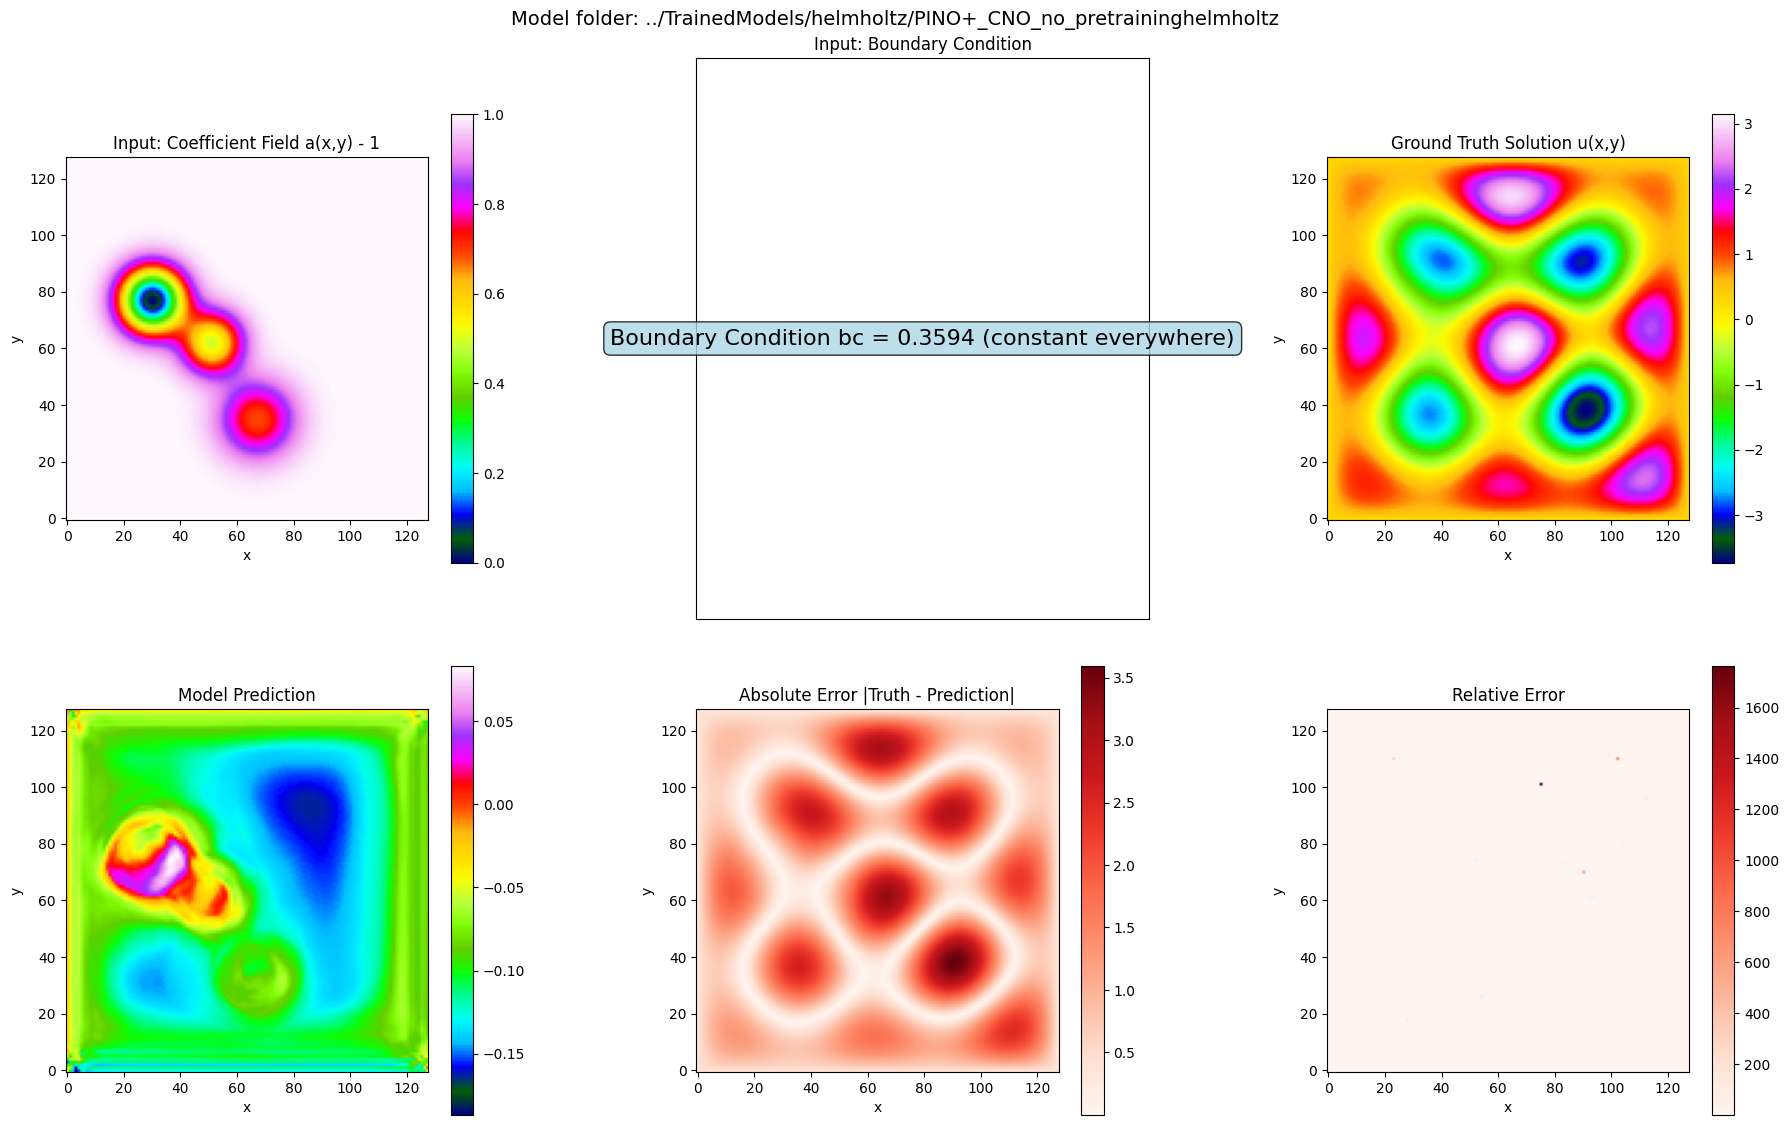

Error metrics for this sample:
  Relative L2 error: 1.0044 (100.44%)
  Maximum absolute error: 3.5910
  Mean absolute error: 1.0742


In [7]:
# Visualize the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Add model folder path as title
fig.suptitle(f"Model folder: {model_folder}", fontsize=14, y=0.98)

# First row - Input and ground truth
# Coefficient field (a-1)
im1 = axes[0, 0].imshow(coeff_field, cmap=cmap_coeff, origin='lower', aspect='equal')
axes[0, 0].set_title('Input: Coefficient Field a(x,y) - 1')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)

# Boundary condition (show as text since it's constant)
axes[0, 1].text(0.5, 0.5, f'Boundary Condition bc = {bc_value:.4f} (constant everywhere)', 
               ha='center', va='center', fontsize=16, 
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_title('Input: Boundary Condition')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# Ground truth solution
im2 = axes[0, 2].imshow(ground_truth, cmap=cmap_solution, origin='lower', aspect='equal')
axes[0, 2].set_title('Ground Truth Solution u(x,y)')
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 2], shrink=0.8)

# Second row - Prediction and error analysis
# Model prediction
im3 = axes[1, 0].imshow(prediction, cmap=cmap_solution, origin='lower', aspect='equal')
axes[1, 0].set_title('Model Prediction')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 0], shrink=0.8)

# Absolute error map
error = np.abs(ground_truth - prediction)
im4 = axes[1, 1].imshow(error, cmap=cmap_error, origin='lower', aspect='equal')
axes[1, 1].set_title('Absolute Error |Truth - Prediction|')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 1], shrink=0.8)

# Relative error map (avoid division by zero)
rel_error_map = np.divide(error, np.abs(ground_truth) + 1e-10)
im5 = axes[1, 2].imshow(rel_error_map, cmap=cmap_error, origin='lower', aspect='equal')
axes[1, 2].set_title('Relative Error')
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('y')
plt.colorbar(im5, ax=axes[1, 2], shrink=0.8)

plt.tight_layout()
plt.show()

# Calculate overall relative error for this sample
rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
max_abs_error = np.max(error)
mean_abs_error = np.mean(error)

print(f"Error metrics for this sample:")
print(f"  Relative L2 error: {rel_error:.4f} ({rel_error*100:.2f}%)")
print(f"  Maximum absolute error: {max_abs_error:.4f}")
print(f"  Mean absolute error: {mean_abs_error:.4f}")


## 5. Multiple Sample Visualization

Let's visualize predictions on multiple samples to get a better sense of model performance across different Helmholtz problems.


Analyzing 4 test samples...
Input batch shape: torch.Size([4, 2, 128, 128])
Output batch shape: torch.Size([4, 1, 128, 128])
Prediction batch shape: torch.Size([4, 1, 128, 128])


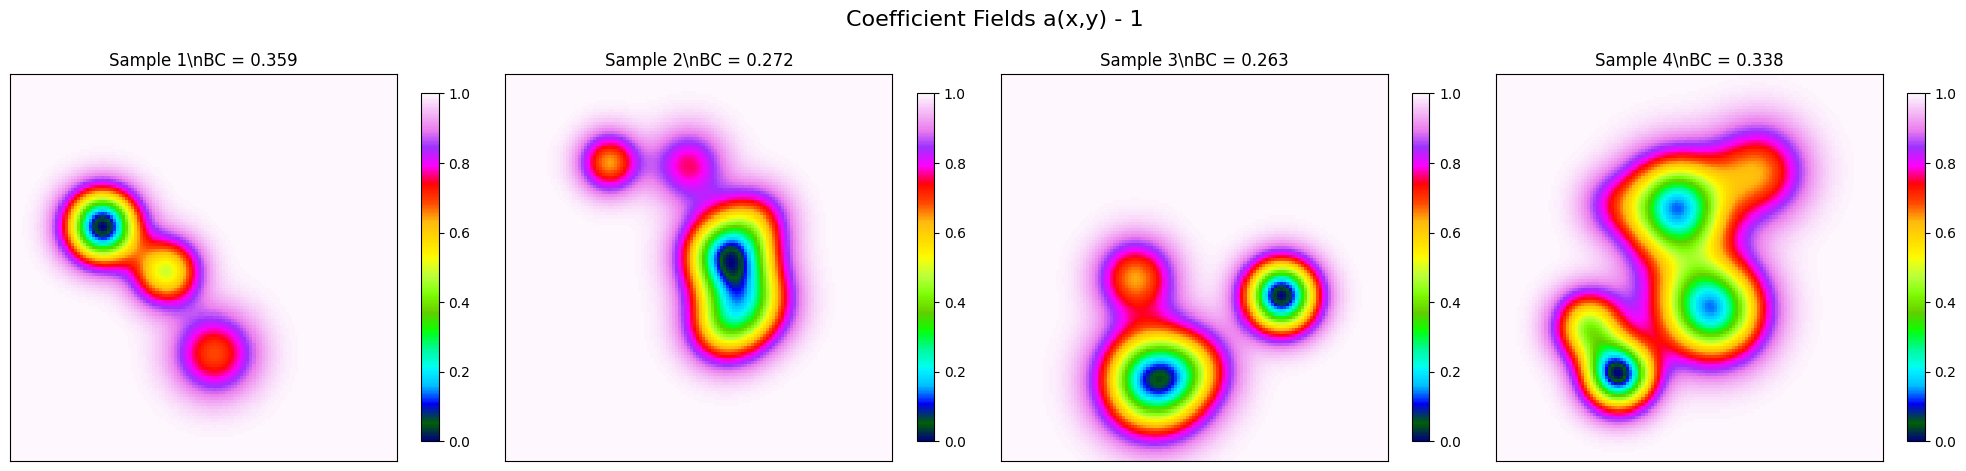

In [8]:
# Get multiple samples for visualization
num_samples = 4
test_iter = iter(helmholtz_data.test_loader)
input_batch, output_batch = next(test_iter)

# Take first few samples
input_batch = input_batch[:num_samples].to(device)
output_batch = output_batch[:num_samples].to(device)

# Get predictions
with torch.no_grad():
    prediction_batch = model(input_batch)

print(f"Analyzing {num_samples} test samples...")
print(f"Input batch shape: {input_batch.shape}")
print(f"Output batch shape: {output_batch.shape}")
print(f"Prediction batch shape: {prediction_batch.shape}")


# Create visualization for coefficient fields
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
fig.suptitle(f"Coefficient Fields a(x,y) - 1", fontsize=16)

for i in range(num_samples):
    # Convert to numpy
    coeff_sample = input_batch[i, 0].cpu().numpy()
    bc_value = input_batch[i, 1, 0, 0].cpu().numpy()
    
    # Plot coefficient field
    im = axes[i].imshow(coeff_sample, cmap=cmap_coeff, origin='lower', aspect='equal')
    axes[i].set_title(f'Sample {i+1}\\nBC = {bc_value:.3f}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], shrink=0.8)

plt.tight_layout()
plt.show()


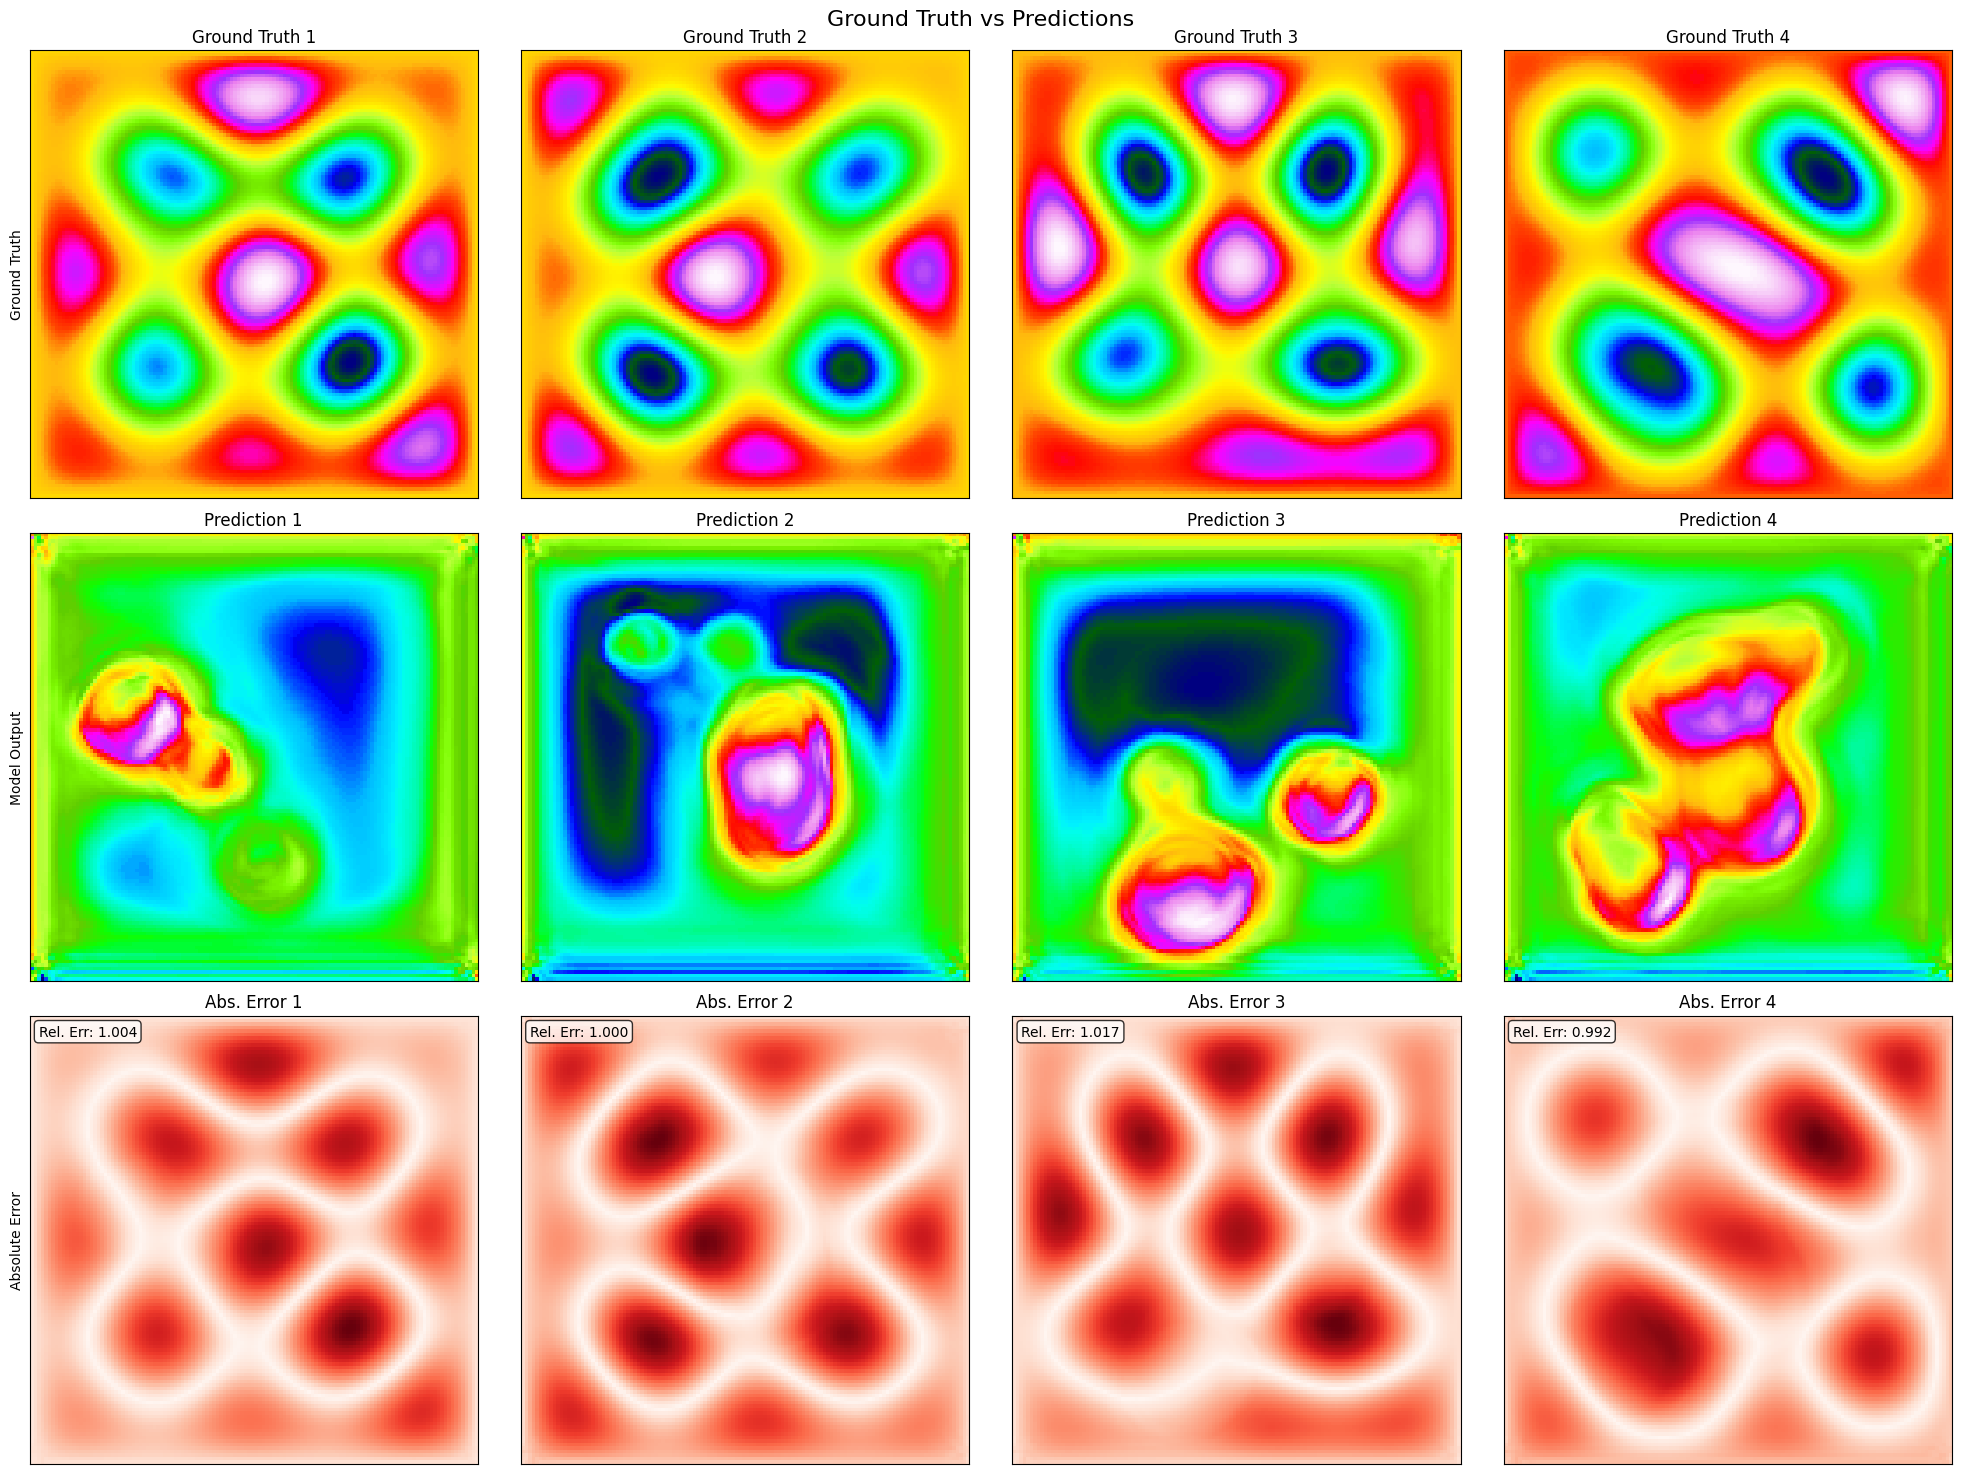

In [9]:
# Create comparison visualization: Ground Truth vs Predictions
fig, axes = plt.subplots(3, num_samples, figsize=(20, 15))
fig.suptitle(f"Ground Truth vs Predictions", fontsize=16)

for i in range(num_samples):
    # Convert to numpy
    ground_truth = output_batch[i, 0].cpu().numpy()
    prediction = prediction_batch[i, 0].cpu().numpy()
    error = np.abs(ground_truth - prediction)
    
    # Plot ground truth
    im1 = axes[0, i].imshow(ground_truth, cmap=cmap_solution, origin='lower', aspect='equal')
    axes[0, i].set_title(f'Ground Truth {i+1}')
    if i == 0:
        axes[0, i].set_ylabel('Ground Truth')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    
    # Plot prediction
    im2 = axes[1, i].imshow(prediction, cmap=cmap_solution, origin='lower', aspect='equal')
    axes[1, i].set_title(f'Prediction {i+1}')
    if i == 0:
        axes[1, i].set_ylabel('Model Output')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
    # Plot error and calculate relative error
    im3 = axes[2, i].imshow(error, cmap=cmap_error, origin='lower', aspect='equal')
    rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
    axes[2, i].set_title(f'Abs. Error {i+1}')
    if i == 0:
        axes[2, i].set_ylabel('Absolute Error')
    axes[2, i].set_xticks([])
    axes[2, i].set_yticks([])
    
    # Add relative error text
    axes[2, i].text(0.02, 0.98, f'Rel. Err: {rel_error:.3f}', 
                   transform=axes[2, i].transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()
